In [32]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import  Dense
from keras.models import Sequential
from keras.optimizers import Adam
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split,KFold

In [ ]:
import os
import numpy as np
import cv2
from sklearn.preprocessing import StandardScaler

# Definir rutas
base_path = '/prj/posgrad/samuelrt/Documentos/Doutorado/images'
hombres_path = os.path.join(base_path, 'homen')
mujeres_path = os.path.join(base_path, 'mulher')

# Tamaño deseado para las imágenes
img_height, img_width = 128, 128  # Un tamaño más pequeño para reducir dimensionalidad

# Listas para almacenar imágenes y etiquetas
imagenes = []
etiquetas = []

# Cargar imágenes de hombres (etiqueta 0) en escala de grises
for imagen_nombre in os.listdir(hombres_path):
    if imagen_nombre.endswith(('.jpg', '.jpeg', '.png')):
        img_path = os.path.join(hombres_path, imagen_nombre)
        # Cargar imagen como escala de grises directamente
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        # Redimensionar
        img = cv2.resize(img, (img_width, img_height))
        # Aplanar la imagen (convertir matriz 2D a vector 1D)
        img_flat = img.flatten()
        imagenes.append(img_flat)
        etiquetas.append(0)  # 0 para hombres

# Cargar imágenes de mujeres (etiqueta 1) en escala de grises
for imagen_nombre in os.listdir(mujeres_path):
    if imagen_nombre.endswith(('.jpg', '.jpeg', '.png')):
        img_path = os.path.join(mujeres_path, imagen_nombre)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (img_width, img_height))
        img_flat = img.flatten()
        imagenes.append(img_flat)
        etiquetas.append(1)  # 1 para mujeres

# Convertir listas a arrays de NumPy
X = np.array(imagenes)
y = np.array(etiquetas)

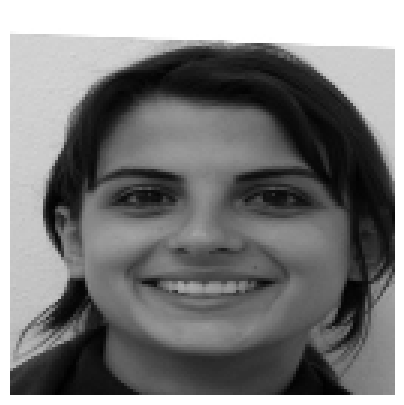

In [7]:
def visualizar_imagen(imagen_flat, altura=64, anchura=64):
    # Reformar el vector aplanado a matriz 2D
    imagen_2d = imagen_flat.reshape(altura, anchura)
    plt.figure(figsize=(5, 5))
    plt.imshow(imagen_2d, cmap='gray')
    plt.axis('off')
    plt.show()

# Para visualizar una imagen del conjunto de entrenamiento
indice = 0  # Cambia el índice para ver diferentes imágenes
visualizar_imagen(X[indice], img_height, img_width)

In [20]:
X.shape

(400, 16384)

In [24]:
df = pd.DataFrame(data=X,columns=[f'P{i}' for i in range(X.shape[1])])
df.loc[:,'target'] = y
df
df.head()

,P0,P1,P2,P3,P4,P5,P6,P7,P8,P9,...,P16375,P16376,P16377,P16378,P16379,P16380,P16381,P16382,P16383,target
0,255,255,255,255,255,255,255,255,255,255,...,130,130,130,131,133,139,139,139,143,0
1,165,167,167,166,167,167,167,172,166,166,...,147,147,147,145,145,137,127,121,119,0
2,187,188,185,185,185,187,188,184,185,183,...,44,54,52,42,42,44,58,59,67,0
3,255,255,255,255,255,255,255,255,255,255,...,13,13,17,20,21,20,21,26,29,0
4,195,191,191,192,194,191,191,193,193,192,...,10,6,12,30,30,30,32,37,42,0


In [25]:
df.value_counts(subset='target')

target
0    200
1    200
Name: count, dtype: int64

In [26]:
# Para obtener el mismo resultado aleatorio cada vez
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [28]:
df.head()

,P0,P1,P2,P3,P4,P5,P6,P7,P8,P9,...,P16375,P16376,P16377,P16378,P16379,P16380,P16381,P16382,P16383,target
0,175,175,179,177,176,177,177,176,175,176,...,80,81,79,78,78,78,77,74,69,1
1,199,200,199,199,201,202,201,200,202,194,...,34,34,33,40,47,42,47,51,46,1
2,183,184,183,184,184,183,184,183,182,184,...,41,58,67,76,79,69,66,76,83,0
3,187,186,187,187,188,189,185,185,187,186,...,112,114,114,113,115,116,117,116,117,1
4,182,182,184,183,181,183,185,184,184,186,...,8,11,15,37,39,42,29,25,38,0


In [38]:
def scaler(x):
    return (x - np.mean(x)) / np.std(x)

In [39]:
X = df.values[:,:-1]
y = df.values[:,-1]

In [40]:
X = scaler(X)

Text(0.5, 1.0, 'Counts')

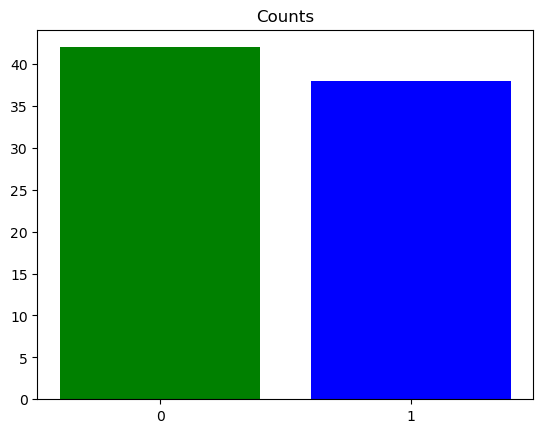

In [59]:
# Separar test y entrenamiento
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clases ,count = np.unique(y_test,return_counts=True)
plt.bar(x=clases,height=count,color=['g','b'])
plt.xticks(clases)
plt.title('Counts')

In [ ]:

# Crear modelo con UNA neurona en la capa oculta
model = Sequential([
    Dense(1, activation='sigmoid', input_shape=(X.shape[1],)),  # solo una neurona
    Dense(1)  # salida para regresión
])
model.compile(optimizer=Adam(), loss='mse')

# K-Fold
kf = KFold(n_splits=4, shuffle=True, random_state=42)

# Entrenar progresivamente
for fold, (train_idx, val_idx) in enumerate(kf.split(X_trainval)):
    X_train_fold, X_val_fold = X_trainval[train_idx], X_trainval[val_idx]
    y_train_fold, y_val_fold = y_trainval[train_idx], y_trainval[val_idx]
    
    print(f"Fold {fold + 1}: entrenando sobre {len(train_idx)} muestras")
    model.fit(X_train_fold, y_train_fold, epochs=10, batch_size=32,
              validation_data=(X_val_fold, y_val_fold), verbose=0)

print("\n✅ Modelo final entrenado en todos los folds con una sola neurona.")


In [45]:
y_pred = model.predict(X_test)

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/stepWARNING:tensorflow:6 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7cbeffe16e80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [35]:
from sklearn.metrics import confusion_matrix,accuracy_score

In [47]:
y_pred = (y_pred >= 0.5).astype(int)

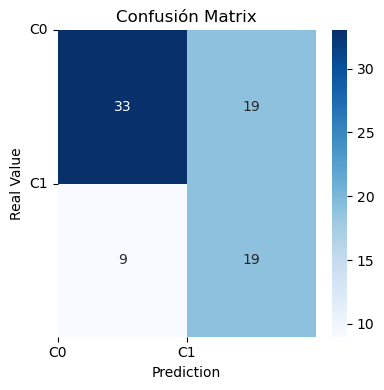

In [48]:
cm = confusion_matrix(y_pred,y_test)
fig, ax = plt.subplots(figsize=(4, 4))
labels = ['C0', 'C1']

# Con seaborn
sb.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels, yticklabels=labels)

# Con matplotlib básico
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.yticks(rotation=0)
plt.ylabel('Real Value')
plt.xlabel('Prediction')
plt.title('Confusión Matrix')
plt.tight_layout()
plt.show()

In [49]:
accuracy_score(y_pred,y_test)

0.65